**To determine the best parameters, architecture, and application, we will use GridSearch. However, in order to reduce the build time, it is necessary to decrease the amount of data**

In [28]:
from sklearn.model_selection import train_test_split
import os
import shutil

data_dir = '/Users/aleksejkitajskij/Desktop/my_project/archive'

# Створення папки для нових навчальних та тестових даних
os.makedirs('new_Train', exist_ok=True)
os.makedirs('new_Validation', exist_ok=True)


# Прохід через папки "Train" і "Test"
for folder in ['Train', 'Validation']:
    folder_path = os.path.join(data_dir, folder)
    new_folder_path = os.path.join('new_'+folder)

    # Прохід через папки для кожної літери/цифри
    for subfolder in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, subfolder)
        if not os.path.isdir(subfolder_path):
            continue

        new_subfolder_path = os.path.join(new_folder_path, subfolder)
        os.makedirs(new_subfolder_path)

        filenames = os.listdir(subfolder_path)

        # Розділення даних на навчальні та тестові
        train_filenames, test_filenames = train_test_split(filenames, train_size = 0.01,test_size=0.01, random_state=42)

        # Копіювання вибраних зображень в нові папки
        for filename in train_filenames:
            src_path = os.path.join(subfolder_path, filename)
            dest_path = os.path.join(new_subfolder_path, filename)
            shutil.copy(src_path, dest_path)

# Вивід кількості зображень у нових наборах даних
print('Number of images in new_train:', sum(len(os.listdir(os.path.join('new_Train', subfolder))) for subfolder in os.listdir('new_Train')))
print('Number of images in new_test:', sum(len(os.listdir(os.path.join('new_Validation', subfolder))) for subfolder in os.listdir('new_Validation')))


Number of images in new_train: 7495
Number of images in new_test: 161


In [36]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_dataCV = train_datagen.flow_from_directory(
    '/Users/aleksejkitajskij/Desktop/my_project/new_Train',
    target_size=(32, 32),
    batch_size=320,
    class_mode='categorical')

test_dataCV = test_datagen.flow_from_directory(
    '/Users/aleksejkitajskij/Desktop/my_project/new_Validation',
    target_size=(32, 32),
    batch_size=320,
    class_mode='categorical')

Found 7495 images belonging to 35 classes.
Found 161 images belonging to 35 classes.


**Building a GridSearch with two functions: call_existing_code that contains our model's parameters, and build_model that generates different variations of these parameters**

In [33]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
import keras_tuner

def call_existing_code(application, units, activation):
            
    input_shape = (32, 32, 3)
        
    app_dic = {'DenseNet201': tf.keras.applications.DenseNet201(include_top=False),
              'EfficientNetB0': tf.keras.applications.EfficientNetB0(include_top=False),
              'VGG16': tf.keras.applications.VGG16(include_top=False)}
    
    pretrained_model = app_dic[application]
    pretrained_model.trainable = False
    inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")

    x = pretrained_model(inputs)
    x = tf.keras.layers.GlobalMaxPooling2D()(x)
    x = tf.keras.layers.Dense(units=units, activation=activation)(x)
    x = tf.keras.layers.Dropout(rate=0.1)(x)  
    
    outputs = tf.keras.layers.Dense(35, activation='softmax')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

def build_model(hp):
    
    app_list = ["DenseNet201","EfficientNetB0","VGG16"]
    
    application = hp.Choice("application", app_list)
    units = hp.Choice("units", [136,256])
    activation = hp.Choice("activation", ["relu", "tanh"])
    
    model = call_existing_code(application=application,
                              units=units,
                              activation=activation)
    return model

tuner = keras_tuner.GridSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    overwrite=True,
    directory="Kytaiskyi",
    project_name="Grid"
)

tuner.search(train_data, epochs=1, validation_data=test_data)


Trial 7 Complete [00h 07m 03s]
val_accuracy: 0.11444984376430511

Best val_accuracy So Far: 0.867598295211792
Total elapsed time: 01h 13m 10s

Search: Running Trial #8

Value             |Best Value So Far |Hyperparameter
EfficientNetB0    |DenseNet201       |application
256               |256               |units
tanh              |relu              |activation

1237/2348 [==============>...............] - ETA: 3:04 - loss: 3.0154 - accuracy: 0.1667

In [37]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    '/Users/aleksejkitajskij/Desktop/my_project/archive/Train',
    target_size=(32, 32),
    batch_size=320,
    class_mode='categorical')

test_data = test_datagen.flow_from_directory(
    '/Users/aleksejkitajskij/Desktop/my_project/archive/Validation',
    target_size=(32, 32),
    batch_size=320,
    class_mode='categorical')

Found 751228 images belonging to 35 classes.
Found 18104 images belonging to 35 classes.


In [17]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
import tensorflow as tf

pretrained_model = VGG16(include_top=False, weights='imagenet', input_shape=(32, 32, 3))
pretrained_model.trainable = False

x = tf.keras.layers.GlobalMaxPooling2D()(pretrained_model.output)
x = Dense(256, activation='relu')(x)
x = Dense(35, activation='softmax')(x)

model2 = Model(inputs=pretrained_model.input, outputs=x)
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history_model2 = model2.fit(train_data,
                          epochs=10,
                          validation_data=test_data,
                          callbacks=[tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=5, min_delta=2)])

Epoch 1/10
2348/2348 [==============================] - 400s 170ms/step - loss: 0.5927 - accuracy: 0.8297 - val_loss: 0.4740 - val_accuracy: 0.8623
Epoch 2/10
2348/2348 [==============================] - 441s 188ms/step - loss: 0.3534 - accuracy: 0.8895 - val_loss: 0.4453 - val_accuracy: 0.8695
Epoch 3/10
2348/2348 [==============================] - 452s 192ms/step - loss: 0.3132 - accuracy: 0.9004 - val_loss: 0.3985 - val_accuracy: 0.8795
Epoch 4/10
2348/2348 [==============================] - 456s 194ms/step - loss: 0.2907 - accuracy: 0.9065 - val_loss: 0.3665 - val_accuracy: 0.8872
Epoch 5/10
2348/2348 [==============================] - 475s 202ms/step - loss: 0.2751 - accuracy: 0.9105 - val_loss: 0.3711 - val_accuracy: 0.8793
Epoch 6/10
2348/2348 [==============================] - 504s 214ms/step - loss: 0.2636 - accuracy: 0.9140 - val_loss: 0.3373 - val_accuracy: 0.8968


In [18]:
# model2.save("final_model.h5")

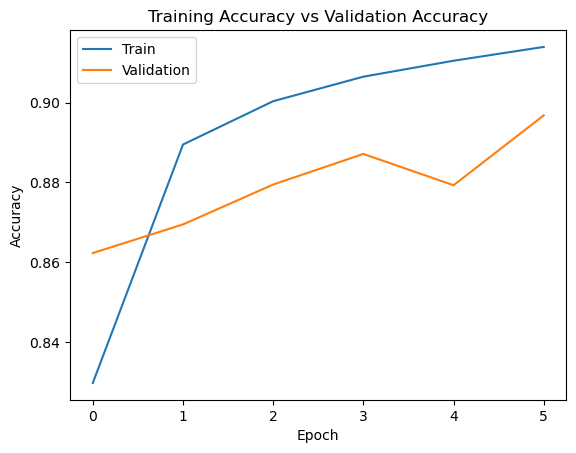

In [20]:
import matplotlib.pyplot as plt

plt.plot(history_model2.history['accuracy'])
plt.plot(history_model2.history['val_accuracy'])
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [40]:
model2.evaluate(test_data)

57/57 [==============================] - 7s 122ms/step - loss: 0.3373 - accuracy: 0.8968


[0.3373206555843353, 0.8968183994293213]